In [7]:
import tt
import numpy as np
import numpy.linalg as nlin
from cvxpy import *

In [8]:
def minimize2(A, index_set, n, m,  r, er_tol):
    M = np.copy(A) 
    X = Variable(n, n*n)
    Y = Variable(n*n, n)
    #for X
    missedX = np.zeros((n, n*n), dtype = bool)
    index_set_1 = [np.unravel_index(i, (n, n*n)) for i in index_set]
    for i in index_set_1:
        missedX[i] = True
    #print missed
    ok_mask_1 = ~missedX
    #print ok__mask
    masked_MX = mul_elemwise(ok_mask_1, np.reshape(M, (n, n*n)))
    masked_X = mul_elemwise(ok_mask_1, X)
    abs_diff1 = abs(masked_X - masked_MX)
    ######## for Y
    missedY = np.zeros((n*n, n), dtype = bool)
    index_set_2 = [np.unravel_index(i, (n*n, n)) for i in index_set]
    for i in index_set_2:
        missedY[i] = True
    #print missed
    ok_mask_2 = ~missedY
    #print ok__mask
    masked_MY = mul_elemwise(ok_mask_2, np.reshape(M, (n*n, n)))
    masked_Y = mul_elemwise(ok_mask_2, Y)
    abs_diff2 = abs(masked_Y - masked_MY)
    
    constraints = [abs_diff1 <= er_tol, abs_diff2 <= er_tol]
    #constraints.append(S >> 0)
    obj = Minimize(norm(X, 'nuc')+ norm(Y, 'nuc'))
    prob = Problem(obj, constraints)
    prob.solve(solver = SCS, verbose = False)
    if prob.status == 'optimal':
        return np.array(X.value),np.array(Y.value)
    return prob.status

In [5]:
d = 3
er_tol = 1e-2
n = np.array([15, 15, 15], dtype = np.int)
rank = 3
T0 = tt.rand(n, d, rank) 
T = T0.full()
m = 800
T_reshaped = np.copy(T.flatten())
N = len(T_reshaped)
index_set = np.arange(N)
np.random.shuffle(index_set)
unknown = index_set[:n[0]**4-m]
known = index_set[m:]
known_indexes = [np.unravel_index(i, np.shape(T)) for i in known]
X,Y = minimize2(T, known_indexes, n[0], m,  rank, er_tol)

In [6]:
d = 3
er_tol = 1e-2
n = np.array([15, 15, 15], dtype = np.int)
rank = 3
T0 = tt.rand(n, d, rank) 
T = T0.full()
mlist = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1500, 1600, 2000, 2500, 3000]
erlist = []
for m in mlist:
    T_reshaped = np.copy(T.flatten())
    N = len(T_reshaped)
    index_set = np.arange(N)
    np.random.shuffle(index_set)
    unknown = index_set[:n[0]**4-m]
    known = index_set[m:]
    known_indexes = [np.unravel_index(i, np.shape(T)) for i in known]
    X, Y, err = minimize2(T, known_indexes, n[0], m,  rank, er_tol)
    print err
    erlist.append(err)

/home/elvira/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


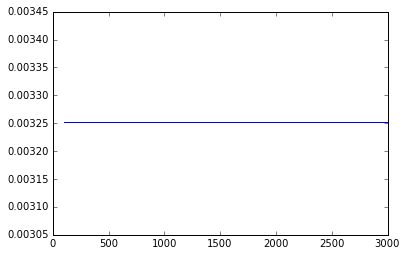

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.array(mlist), np.array(erlist))

In [8]:
erlist

[0.0032520877922942054,
 0.0032520877922942054,
 0.0032520877922942054,
 0.0032520877922942054,
 0.0032520877922942054,
 0.0032520877922942054,
 0.0032520877922942054,
 0.0032520877922942054,
 0.0032520877922942054,
 0.0032520877922942054,
 0.0032520877922942054,
 0.0032520877922942054,
 0.0032520877922942054,
 0.0032520877922942054,
 0.0032520877922942054]

# ALS

In [5]:
def vec_shrink(x, nu):
    return np.maximum(x-nu, np.zeros(np.shape(x)))

def Shrink(R, nu):
    u,s,v = nlin.svd(R, full_matrices=False)
    s_new = vec_shrink(s, nu)
    return np.dot(u, np.dot(np.diag(s_new), v))

def updateLambda(old, Xk,M):
    return old+mu*(Xk-M)

def updateM(X, Lambda, alpha, beta):
    Y = np.reshape(X, np.shape(Lambda))
    #print alpha
    #eturn Shrink(Y+Lambda/beta, alpha/beta)
    return Shrink(Y, alpha/beta)

def updateX(X, M_array, Lambda_array, beta_array):
    #pint np.shape(X)
    for k in range(d-1):
    # X += beta_array[0,k]*np.reshape(M_array[k]-Lambda_array[k], np.shape(T))
        X += beta_array[k]*np.reshape(M_array[k], np.shape(T))
    X = X/np.sum(beta_array)
    X = X.flatten()
    X[known] = T_reshaped[known]
    X = np.reshape(X, np.shape(T))
    return X

def ALS(T, known, betas, mu, maxiter):
    #Initial guesses of M_k and Lambdas:
    Ms = []
    Lambdas =[]
    for k in range(d-1):
        Ms.append(np.zeros((np.prod(np.shape(T)[:k+1]), np.prod(np.shape(T))/np.prod(np.shape(T)[:k+1]))))
        Lambdas.append(np.zeros((np.prod(np.shape(T)[:k+1]), np.prod(np.shape(T))/np.prod(np.shape(T)[:k+1]))))
    # Initial guess for X:
    #rint len(Ms)
    X = np.zeros(np.shape(T),dtype = np.double)
    
    for i in range(maxiter):
    #Update the tensor X:
        X = updateX(X, Ms, Lambdas, betas)
    #Update all of the Lambdas:
    #  for k in range(d-1):
    #       Lambdas[k]= updateLambda(Lambdas[k], np.reshape(X, np.shape(Ms[k])), Ms[k])
    #Update all of the matrices M:
        alpha = np.shape(T)[0]+np.shape(T)[1]*nlin.norm(Ms[1], 'nuc')
        #rint alpha
        Ms[0] = updateM(X, Lambdas[0],alpha, betas[0])
        for k in range(1, d-2):
            alpha =  np.shape(T)[k]*nlin.norm(Ms[k-1], 'nuc')+ np.shape(T)[k+1]*nlin.norm(Ms[k+1], 'nuc')
            Ms[k] = updateM(X, Lambdas[k],alpha, betas[k])
        alpha= np.shape(T)[d-2]*nlin.norm(Ms[d-3], 'nuc')+np.shape(T)[d-1]
        Ms[d-2] = updateM(X, Lambdas[d-2],alpha,betas[d-2])
        #rint 'X:', np.shape(X)
        #rint np.shape(T)
        print 'error:', nlin.norm(T_reshaped-X.flatten())/nlin.norm(T_reshaped)
    return X, nlin.norm(T_reshaped-X.flatten())/nlin.norm(T_reshaped)

In [8]:
d = 4
n = np.array([15, 15, 15, 15], dtype = np.int)
rank = 3
T0 = tt.rand(n, d, rank) 
T = T0.full()
m = 30000
mu = 0.5
#T = np.random.randn(2,2,2,2,2,2,2,2,2,2)
T_reshaped = np.copy(T.flatten())
N = len(T_reshaped)
index_set = np.arange(N)
np.random.shuffle(index_set)
unknown = index_set[:m]
known = index_set[m:]
success = 0

f = 0.1
maxiter = 1000
betas = np.zeros(d-1)
for i in range(d-1):
    betas[i] = np.maximum(np.prod(np.shape(T)[:i+1]), np.prod(np.shape(T))/np.prod(np.shape(T)[:i+1]))
betas = betas/np.sum(betas) 
betas = betas*f

mu = 1e-3
errlist = []

Y, error = ALS(T, known, betas, mu, maxiter)


error: 0.753948795359
error: 0.691504776936
error: 0.523446348581
error: 8.86138099165
error: 102.520044303
error: 1129.84965558
error: 12397.3448001
error: 135976.324628
error: 1491358.68411
error: 16356842.6268
error: 179397634.256
error: 1967586961.81
error: 21579986038.2
error: 236683717843.0
error: 2.59588593764e+12
error: 2.8471007058e+13
error: 3.12262658056e+14
error: 3.42481624964e+15
error: 3.75625008025e+16
error: 4.11975815254e+17
error: 4.51844442536e+18
error: 4.95571324072e+19
error: 5.43529839305e+20
error: 5.96129501173e+21
error: 6.538194529e+22
error: 7.1709230318e+23
error: 7.8648833252e+24
error: 8.62600106635e+25
error: 9.46077536309e+26
error: 1.03763342692e+28
error: 1.13804956501e+29
error: 1.24818339388e+30
error: 1.36897533522e+31
error: 1.50145681928e+32
error: 1.64675909211e+33
error: 1.80612287522e+34
error: 1.98090895992e+35
error: 2.17260982701e+36
error: 2.38286239091e+37
error: 2.61346197713e+38
error: 2.86637765233e+39
error: 3.14376903804e+40
error: 

/home/elvira/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: overflow encountered in double_scalars
/home/elvira/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:51: RuntimeWarning: overflow encountered in double_scalars


error: inf
error: inf
error: inf


ValueError: On entry to DLASCL parameter number 5 had an illegal value